# Условие

In [146]:
{'mail': 'kiselev.ns@phystech.edu',
 'id': 3022327224,
 'type': 'regression',
 'dataset': {'name': 'Forest Fires Data Set',
  'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
 'method': ['Перцептрон', 'Надарая-Ватсона', 'SVR']}

{'mail': 'kiselev.ns@phystech.edu',
 'id': 3022327224,
 'type': 'regression',
 'dataset': {'name': 'Forest Fires Data Set',
  'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
 'method': ['Перцептрон', 'Надарая-Ватсона', 'SVR']}

# Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy.stats import zscore
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# Загрузка выборки

In [3]:
data = pd.read_csv("forestfires.csv")
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Анализ выборки

## Определение типов признаков

Определим размер выборки и количество признаков.

In [4]:
data.shape

(517, 13)

Объем выборки составляет 517 объектов. Каждый из них характеризуется 12 признаками. Целевая переменная — площадь сгоревшего леса в гектарах.

Рассмотрим подробнее каждый из признаков. Проверим, нет ли пропущенных значений.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


Заметим, что в выборке нет пропущенных значений признаков.

For more information, read [Cortez and Morais, 2007].
   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: 'jan' to 'dec' 
   4. day - day of the week: 'mon' to 'sun'
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).

Посмотрим на распределение значений каждого признака.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


Среди признаков есть 2 категориальных: month, day, 2 порядковых: X, Y, а также 8 числовых (все оставшиеся). С порядковыми признаками можно работать различными способами. Тем не менее, не будем преобразовывать их в категориальные, чтобы не терять отношение порядка.

In [7]:
target = 'area'

cat_columns = data.drop(columns=target).select_dtypes(include='object').columns.tolist()
num_columns = data.drop(columns=target).select_dtypes(exclude='object').columns.tolist()

cat_columns, num_columns

(['month', 'day'],
 ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'])

## Визуальный анализ данных

### Целевая переменная

Для начала построим график распределения целевой переменной. Это, помимо всего прочего, позволит нам определить, есть ли в данных выбросы.

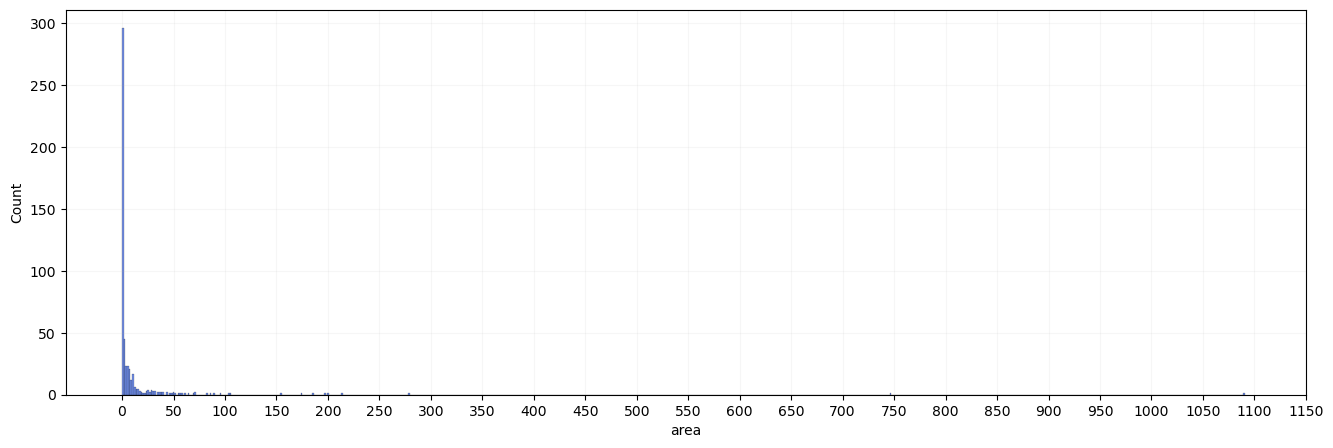

In [8]:
plt.figure(figsize=(16, 5))
sns.histplot(data[target], fill=True, color='royalblue')
plt.xticks([i for i in range(0, 1200, 50)])
plt.grid(alpha=0.1)
plt.show()

Видно, что большинство пожаров затрагивают малую площадь поверхности. Для практически всех объектов значение целевой переменной менее 50. Для того, чтобы предложенные методы работали хорошо, возможно, стоит применить какое-нибудь преобразование, например, логарифмирование. Кроме того, можно наблюдать несколько "выбросов" — пожары площадью порядка 280, 750 и 1100. Далее подумаем над тем, чтобы исключить их из рассматриваемой выборки.

Рассмотрим "выбросы". Определим их по отклонению значения целевой переменной больше, чем на три среднеквадратичных отклонения.

In [9]:
outliers = data[abs(zscore(data[target])) >= 3 ]
outliers

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
237,1,2,sep,tue,91.0,129.5,692.6,7.0,18.8,40,2.2,0.0,212.88
238,6,5,sep,sat,92.5,121.1,674.4,8.6,25.1,27,4.0,0.0,1090.84
415,8,6,aug,thu,94.8,222.4,698.6,13.9,27.5,27,4.9,0.0,746.28
479,7,4,jul,mon,89.2,103.9,431.6,6.4,22.6,57,4.9,0.0,278.53


---

In [10]:
data = data[abs(zscore(data[target])) < 3 ]

In [11]:
data[target] = np.log1p(data[target])

---

### Категориальные признаки

Построим графики распределения категориальных признаков.

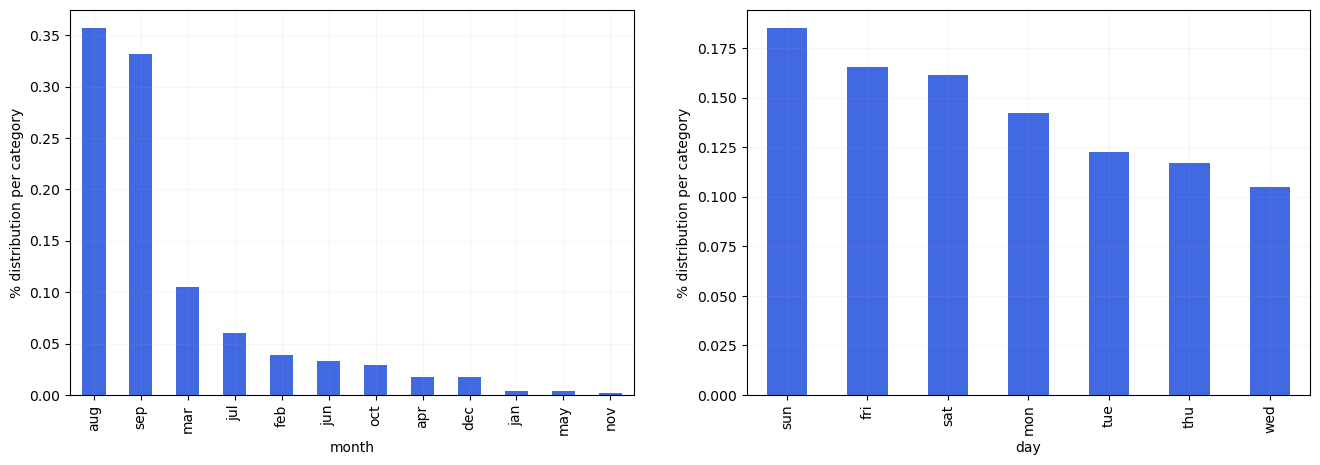

In [13]:
plt.figure(figsize=(16, 5))

for i, col in enumerate(cat_columns, start=1):
    plt.subplot(1, 2, i)
    data[col].value_counts(normalize=True).plot.bar(color='royalblue')
    plt.xlabel(col)
    plt.ylabel("% distribution per category")
    plt.grid(alpha=0.1)

plt.show()

Из графиков можно заметить, что наибольшее число пожаров произошло за два месяца — август и сентябрь. Распределение по дням недели навряд ли имеет какую-либо статистическую значимость, но тем не менее пятница и воскресенье лидируют в этом вопросе.

### Числовые признаки

Для числовых признаков также построим графики распределения.

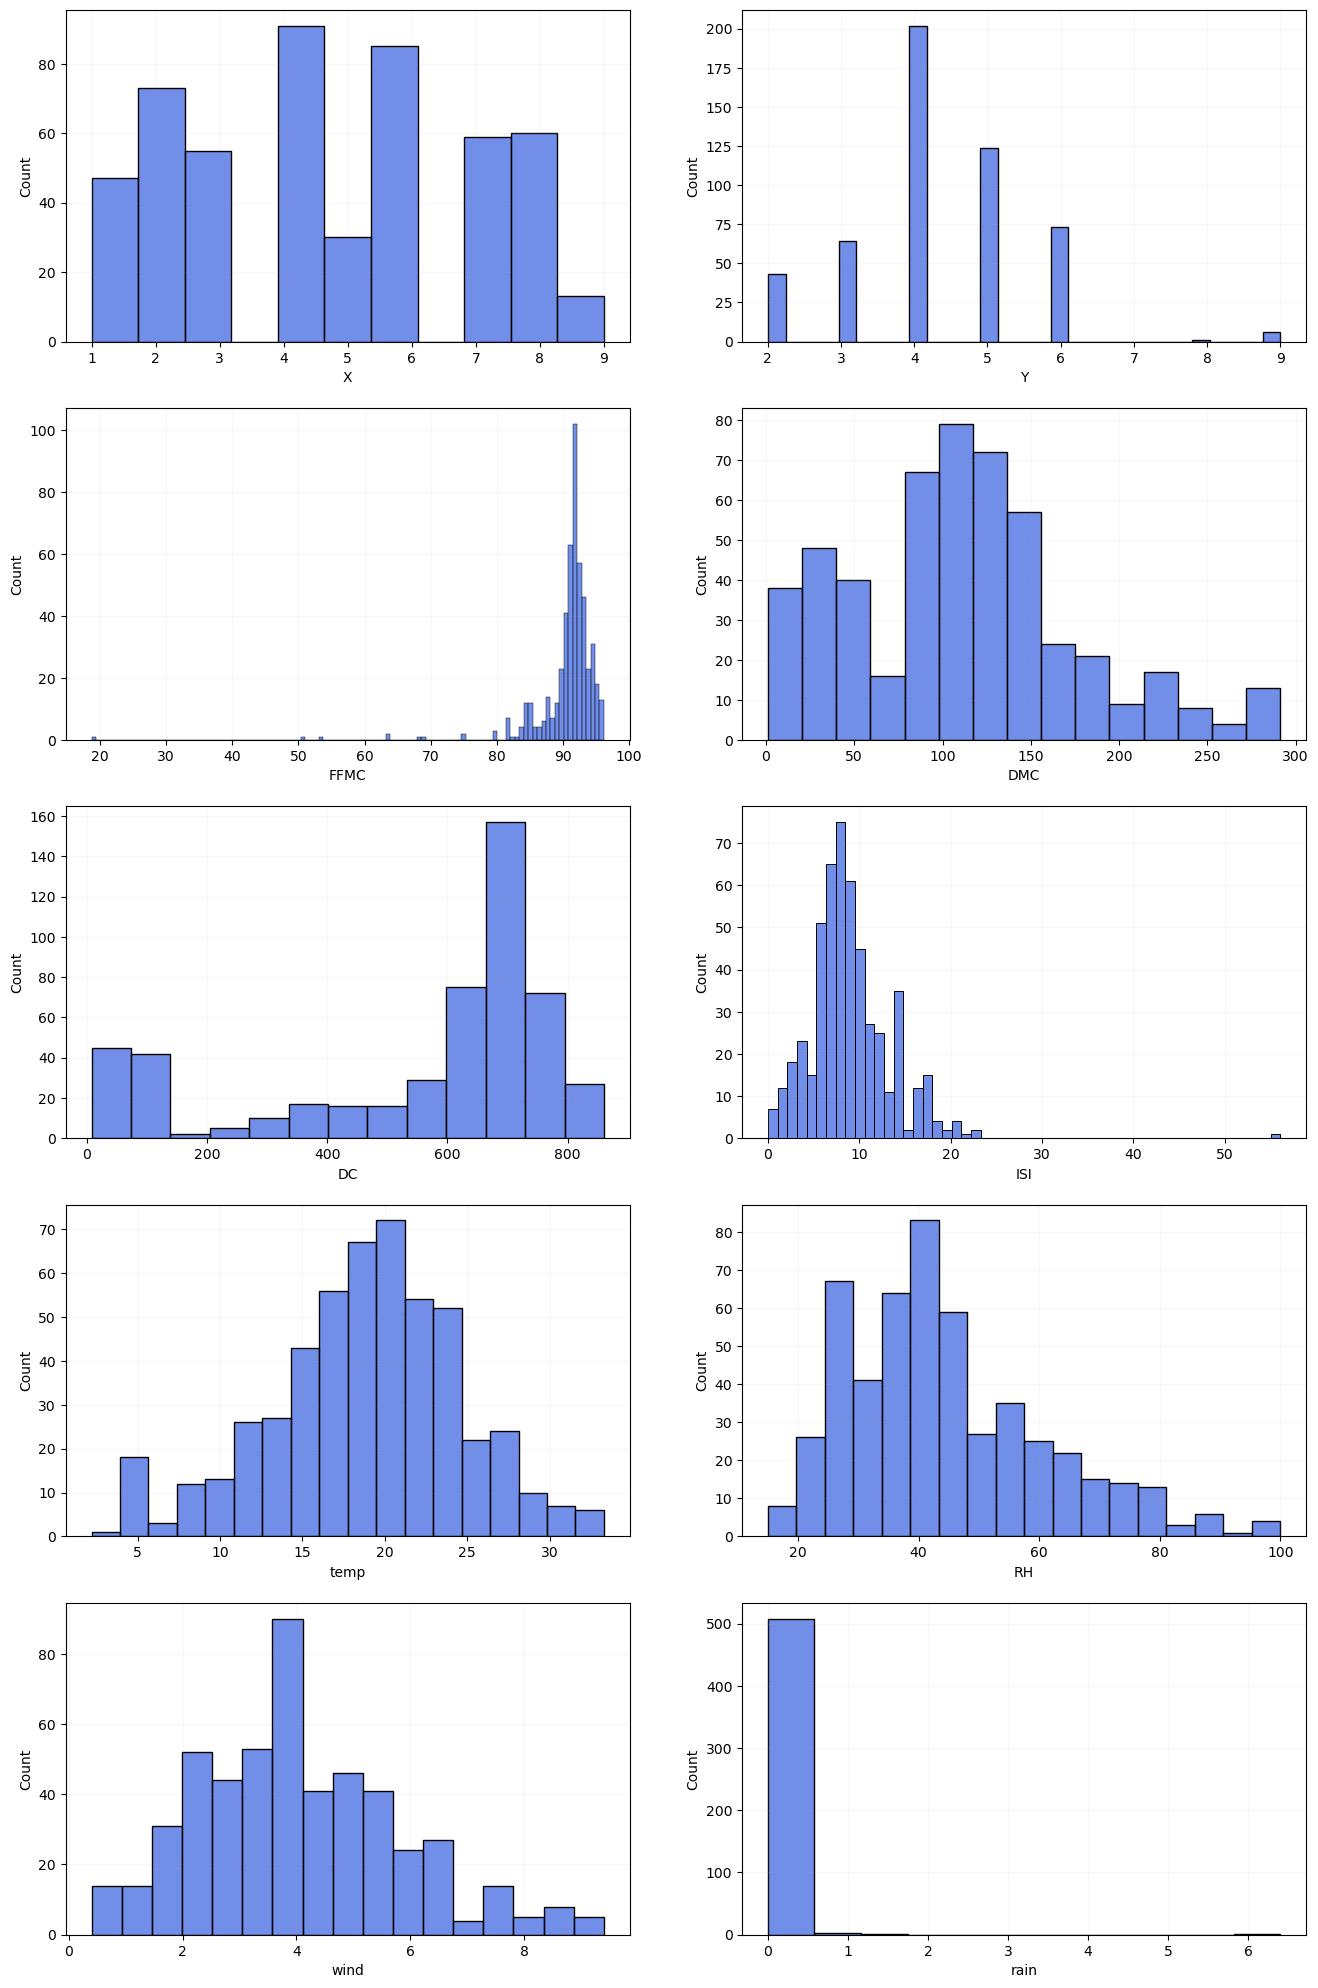

In [14]:
plt.figure(figsize=(16, 25))

for i, col in enumerate(num_columns, start=1):
    plt.subplot(5, 2, i)
    sns.histplot(data[col], fill=True, color='royalblue')
    #plt.xlabel(col)
    #plt.ylabel("% distribution per category")
    plt.grid(alpha=0.1)

plt.show()

Можно обратить внимание на то, что по значениям признаков FFMC и ISI наблюдаются "выбросы". Возможно, в дальнейшем стоит исключить эти объекты для достижения лучшего результата. Кроме того, признак rain для практически всех объектов имеет нулевое значение, поэтому, на мой взгляд, вместо него стоит ввести новый категориальный признак — наличие/отсутствие дождя.

Положения пожаров на рассматриваемой местности фиксируются координатами X и Y, поэтому для визуализации данных построим 2D-гистограмму частот пожаров в этих областях.

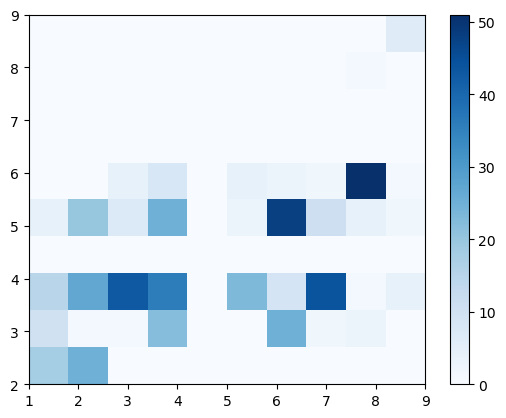

In [15]:
plt.hist2d(data['X'], data['Y'], cmap='Blues')
plt.colorbar()
plt.show()

Теперь построим графики попарных зависимостей между признаками, а также целевой переменной.

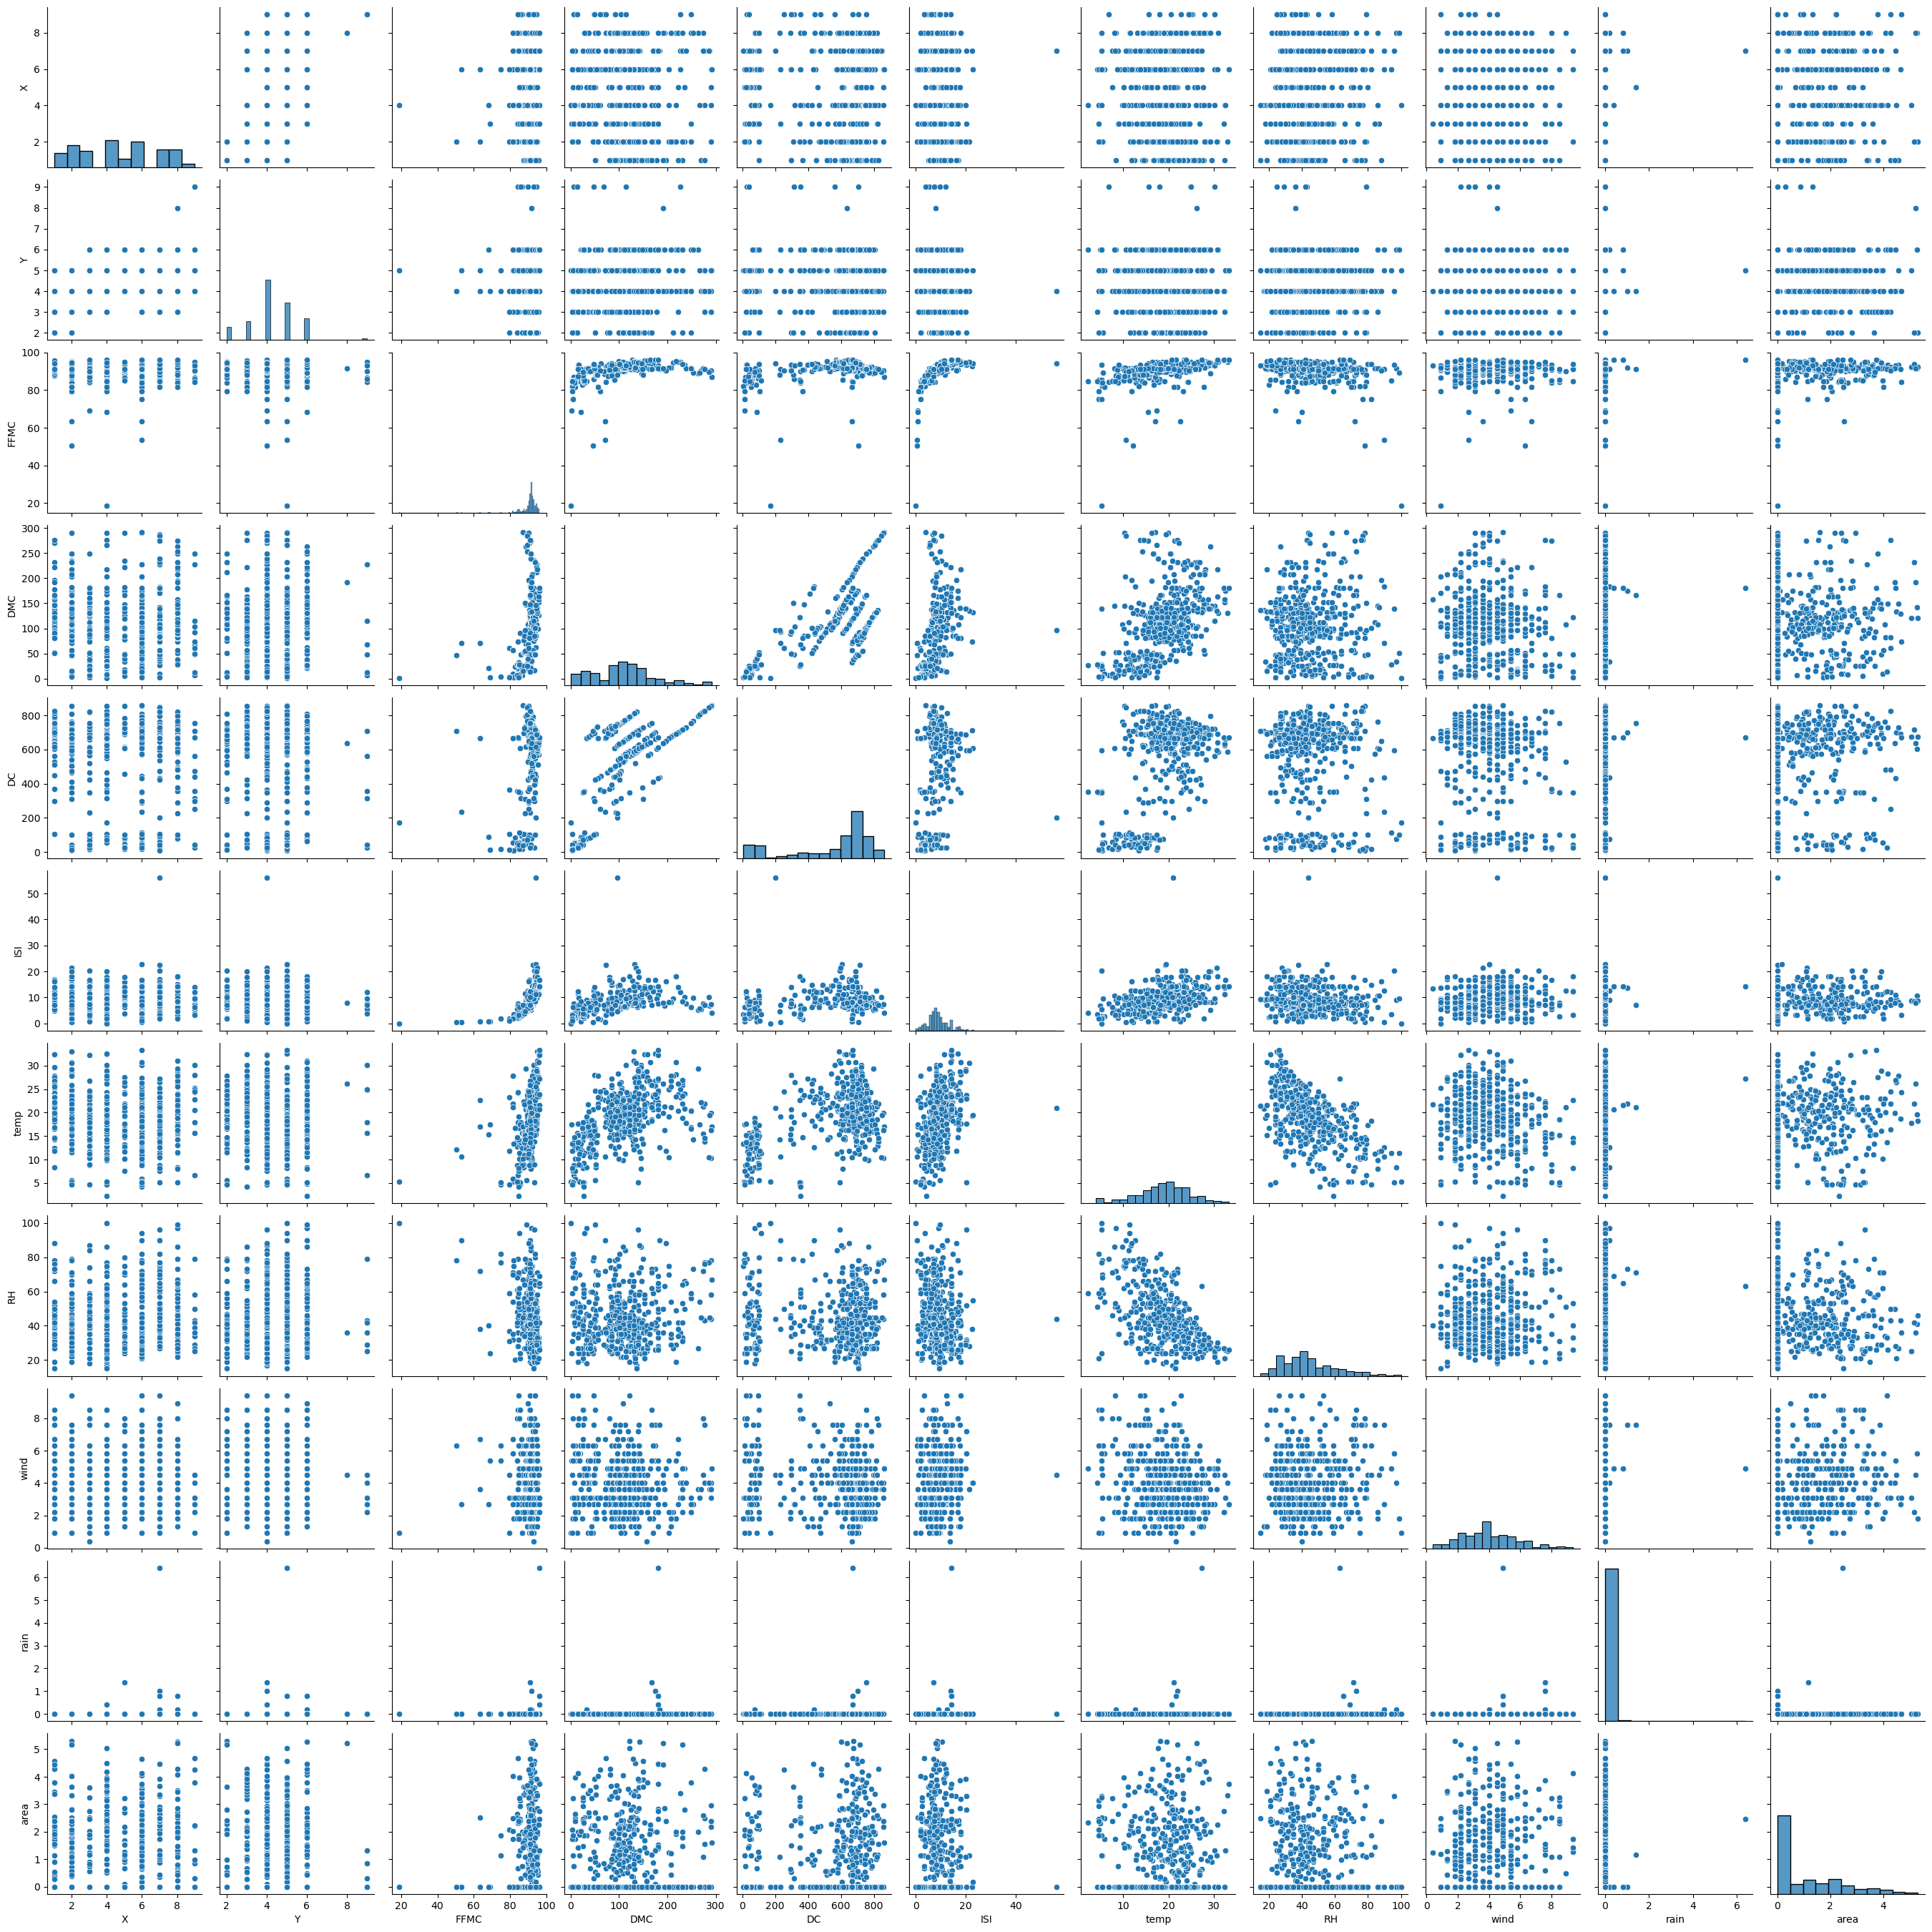

In [16]:
sns.pairplot(data)
plt.show()

Можно заметить, что для некоторых признаков (например, DMC и DC) наблюдается практически линейная зависимость. Это наводит на мысль о построении матрицы корреляции, чтобы проверить, нет ли мультиколлинеарности.

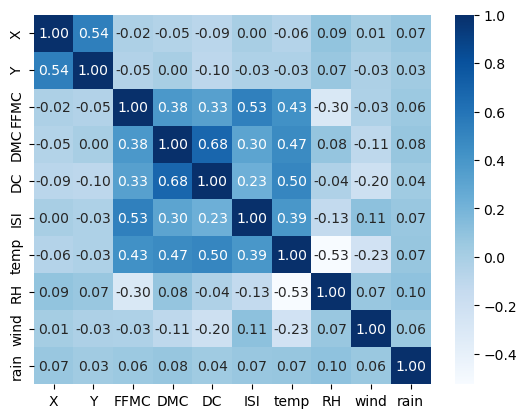

In [17]:
sns.heatmap(data[num_columns].corr(), annot=True, cmap='Blues', fmt=".2f")
plt.show()

Видно, что между признаками FFMC, DMC, DC, ISI и temp наблюдается достаточно сильная линейная зависимость. Это естественным образом связано с природой полученных данных. Рассматриваемые признаки характеризуют погодные условия, а конкретнее — некоторые параметры, связанные с влажностью и температурой.

# Предобработка данных

## Преобразование категориальных признаков в вещественные

Преобразование будем проводить с помощью процедуры OneHotEncoding. (Применение смотреть далее в Pipeline)

## Нормировка признаков

Нормировка признаков будет производиться отдельно на train и test. Причем на train мы будем использовать k-fold кросс-валидацию, каждый раз заново нормируя тренировочную часть выборки и используя полученные параметры для нормировки тестовой части. На отложенной тестовой части выборки будут использоваться параметры, полученные при нормировке всего train. (Применение смотреть далее в Pipeline)

Разделим данные на train и test в соотношении 70:30.

In [18]:
X, y = data.drop(columns=target), data[target]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [20]:
X.shape

(513, 12)

In [21]:
X_train.shape

(359, 12)

# Эксперименты для предложенных методов

Создадим ColumnTransformer, чтобы отдельно обрабатывать числовые и категориальные признаки. Для обработки числовых будем использовать StandardScaler, а для категориальных OneHotEncoder.

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_columns)
    ]
)

## Перцептрон

В качестве модели перцептрона будем использовать MLPRegressor из sklearn.neural_network.

In [23]:
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('mlp', MLPRegressor())
    ]
)

Будем варьировать следующие гиперпараметры:
- `hidden_dim` - размерность скрытого слоя: `10, 20, 50, 100`
- `num_layers` - количество скрытых слоев: `1, 2, 3, 4, 5`
- `learning_rate_init` - значение learning rate для оптимайзера Adam: `1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1`
- `alpha` - коэффициент L2-регуляризации, добавляемой к MSE: `1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1`

In [24]:
param_grid = {
    'mlp__hidden_layer_sizes': [[hidden_dim for _ in range(num_layers)] for hidden_dim in [10, 20, 50, 100] for num_layers in [1, 2, 3, 4, 5]],
    'mlp__learning_rate_init': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'mlp__alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}

В качестве метрики для сравнения моделей будем использовать MSE (если быть точным, то -MSE, поскольку GridSearchCV считает лучшим именно большее значение).

In [25]:
search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [26]:
search.fit(X_train, y_train)

Рассмотрим параметры, при которых достигается наилучшее качество.

In [ ]:
search.best_params_

{'mlp__alpha': 1e-05,
 'mlp__hidden_layer_sizes': [20, 20, 20, 20, 20],
 'mlp__learning_rate_init': 0.1}

Сделаем предсказание на отложенной тестовой подвыборке и подсчитаем значение MSE.

In [ ]:
MSE_perceptron = -search.score(X_test, y_test)
print(f"MSE: {MSE_perceptron:.4f}")

MSE: 2.6496


## Надарая-Ватсона

Рассмотрим следующую имплементацию формулы Надарая-Ватсона, частично взятую из семинаров.

In [315]:
class FNV(sklearn.base.BaseEstimator):
    def __init__(self, kernel=None, h=None):
        self.X, self.Y = None, None
        self.kernel = lambda distance, h: np.ones_like(distance)
        self.h = 1
        if kernel is not None:
            self.kernel = kernel
        if h is not None:
            self.h = h
    def predict(self, X):
        features = np.sum(self.Y * self.kernel(cdist(X, self.X), self.h), axis=-1)
        return features / (np.sum(self.kernel(cdist(X, self.X), self.h), axis=-1) + 1e-10)
    def fit(self, X, Y):
        self.X, self.Y = np.array(X), np.array(Y)

Будем рассматривать несколько видов ядер:
- $\Pi(r) = [|r| \leqslant 1]$ — прямоугольное
- $T(r) = \left(1 - |r|\right)[|r| \leqslant 1]$ — треугольное
- $E(r) = \left(1 - r^2\right)[|r| \leqslant 1]$ — квадратичное (Епанечникова)
- $Q(r) = \left(1 - r^2\right)^2[|r| \leqslant 1]$ — квартическое
- $G(r) = \exp\left(-2r^2\right)$ — гауссовское

In [316]:
# прямоугольное ядро
def Pi(distance, h=1):
    r = np.array(distance) / h
    return np.abs(r) <= 1

# треугольное ядро
def T(distance, h=1):
    r = np.array(distance) / h
    return (1 - np.abs(r)) * (np.abs(r) <= 1)

# квадратичное ядро (Епанечникова)
def E(distance, h=1):
    r = np.array(distance) / h
    return (1 - r**2) * (np.abs(r) <= 1)

# квартическое ядро
def Q(distance, h=1):
    r = np.array(distance) / h
    return (1 - r**2)**2 * (np.abs(r) <= 1)

# гауссовское ядро
def G(distance, h=1):
    r = np.array(distance) / h
    return np.exp(-2 * r**2)

In [317]:
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('fnv', FNV())
    ]
)

Будем варьировать следующие гиперпараметры:
- `kernel` - ядро: `Pi, T, E, Q, G`
- `h` - ширина окна: `np.logspace(-3, 3, 100)`

In [318]:
param_grid = {
    'fnv__kernel': [Pi, T, E, Q, G],
    'fnv__h': np.logspace(-3, 3, 100)
}

In [319]:
search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)

In [320]:
search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['X',
                                                                          'Y',
                                                                          'FFMC',
                                                                          'DMC',
                                                                          'DC',
                                                                          'ISI',
                                                                          'temp',
                                                                          'RH',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('fnv',
                                        FNV(h=1,
                                            kernel=<function FNV.__init__.<locals>.<lambda> at 0x000001AB35CEA5E0>))]),
             n_jobs=-1,
             param_gri...
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03]),
                         'fnv__kernel': [<function Pi at 0x000001AB33426EE0>,
                                         <function T at 0x000001AB35CBE820>,
                                         <function E at 0x000001AB34DCB790>,
                                         <function Q at 0x000001AB34DCB820>,
                                         <function G at 0x000001AB34DCBEE0>]},
             scoring='neg_mean_squared_error')

Рассмотрим параметры, при которых достигается наилучшее качество.

In [321]:
search.best_params_

{'fnv__h': 3.2745491628777286,
 'fnv__kernel': <function __main__.G(distance, h=1)>}

Сделаем предсказание на отложенной тестовой подвыборке и подсчитаем значение MSE.

In [322]:
MSE_fnv = -search.score(X_test, y_test)
print(f"MSE: {MSE_fnv:.4f}")

MSE: 2.1689


## SVR

In [323]:
pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('svr', SVR())
    ]
)

Будем варьировать следующие гиперпараметры:
- `kernel` - ядро: `linear, poly, rbf, sigmoid, precomputed`
- `h` - ширина окна: `np.logspace(-3, 3, 7)`

In [324]:
param_grid = {
    'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'svr__C': np.logspace(-3, 3, 7)
}

In [325]:
search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

In [326]:
search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['X',
                                                                          'Y',
                                                                          'FFMC',
                                                                          'DMC',
                                                                          'DC',
                                                                          'ISI',
                                                                          'temp',
                                                                          'RH',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('svr', SVR())]),
             n_jobs=-1,
             param_grid={'svr__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                         'precomputed']},
             scoring='neg_mean_squared_error')

Рассмотрим параметры, при которых достигается наилучшее качество.

In [327]:
search.best_params_

{'svr__C': 1.0, 'svr__kernel': 'rbf'}

Сделаем предсказание на отложенной тестовой подвыборке и подсчитаем значение MSE.

In [328]:
MSE_svr = -search.score(X_test, y_test)
print(f"MSE: {MSE_svr:.4f}")

MSE: 2.3804


# Описание полученных результатов